<div align="center" style="width: 100%; background-color: #E9E9EA; margin-bottom: 3em;">
    <h1 style="font-family: courier; font-size: 4em; padding-top: .5em;"><b>Historical Sales and Active Inventory</b></h1>
    <img src="../img/sales-inventory.png">    
</div>

# Data Exploration

---

## Historical Sales and Active Inventory

A análise de dados permite que as empresas entendam sua eficiência e desempenho e, finalmente, ajuda a empresa a tomar decisões mais informadas. Por exemplo, uma empresa de comércio eletrônico pode ter interesse em analisar os atributos do cliente para exibir anúncios segmentados para melhorar as vendas. A análise de dados pode ser aplicada a quase qualquer aspecto de um negócio, se entendermos as ferramentas disponíveis para processar informações.

A **Análise Exploratória de Dados** desempenha um papel crítico na compreensão do quê, por que e como na análise de um problema. É o primeiro passo na ordem de operações que um analista de dados executará ao entregar uma análise.

> Aqui está uma definição simples: A análise exploratória de dados é uma abordagem para analisar conjuntos de dados, resumindo suas principais características com visualizações.

O processo de AED é um passo crucial antes da construção de um modelo robusto. Esta exemplo apresenta os principais componentes da análise exploratória de dados, a fim de que você possa começar a analisar seus próprios dados. Abordaremos algumas explicações teóricas relevantes, bem como exemplos de código para que você possa aplicar essas técnicas ao seu próprio conjunto de dados.

**Objetivos**
* Ler e examinar um conjunto de dados
* Classificar variáveis por tipo: quantitativo x categórico
* Trabalhar com variáveis categóricas
* Realize análises univariadas e bivariadas e obtenha insights significativos sobre o conjunto de dados
* Identificar e tratar valores ausentes e discrepantes no conjunto de dados
* Construir uma matriz de correlação para identificar variáveis relevantes

## Historical Sales and Active Inventory

### Descrição do problema:

* **Contexto** - Uma empresa de varejo tem muitos produtos em seu inventário, e muito poucos deles tendem a vender (apenas cerca de 10% vendem a cada ano) e muitos dos produtos têm apenas uma única venda no curso de um ano.
* **Objetivo** - A equipe de vendas e crescimento da empresa de varejo quer determinar quais produtos de seus estoques devem reter para vender e quais deles descartar
* **Dados** - Todos os dados históricos de vendas e inventário ativo. link: [https://www.kaggle.com/flenderson/sales-analysis](https://www.kaggle.com/flenderson/sales-analysis)

---

**1º passo:** Vamos fazer o download do arquivo que será trabalhado...

In [26]:
import requests

url = 'https://meriatdatasets.blob.core.windows.net/public/SalesKaggle3.csv'
myfile = requests.get(url, allow_redirects=True)
open('../data/911.csv', 'wb').write(myfile.content)

13595360

In [27]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
from matplotlib import pyplot as plt

Vamos analisar o conjunto de dados e examinar mais de perto seu conteúdo. O objetivo aqui é encontrar detalhes como o número de colunas e outros metadados que nos ajudarão a avaliar o tamanho e outras propriedades, como o intervalo de valores nas colunas do conjunto de dados.

Para obter um pouco mais de contexto sobre os dados, é necessário entender o que as colunas significam em relação ao contexto do negócio - isso ajuda a estabelecer regras para as possíveis transformações que podem ser aplicadas aos valores da coluna.

O ideial é sempre obter o data sheet dos dados. Nesse caso é fácil por estar documentado no Kaggle. Aqui estão as definições importantes das colunas:

* **File_Type**:  O valor "Active" significa que o produto específico precisa de investigação
* **SoldFlag**:  O valor 1 = venda, 0 = sem venda nos últimos seis meses
* **SKU_number**:  Esse é o identificador exclusivo de cada produto.
* **Order**:  Apenas um contador seqeencial. Pode ser ignorado.
* **SoldFlag**:  1 = vendido nos últimos 6 meses. 0 = não vendido
* **MarketingType**:  Neste caso se trata das duas categorias que definem como o produto é comercializado.
* **New_Release_Flag**:  Qualquer produto que tenha uma versão futura caso esse número seja > 1.

In [28]:
sales_data = pd.read_csv("../data/SalesKaggle3.csv")
sales_data.head()

,Order,File_Type,SKU_number,SoldFlag,SoldCount,MarketingType,ReleaseNumber,New_Release_Flag,StrengthFactor,PriceReg,ReleaseYear,ItemCount,LowUserPrice,LowNetPrice
0,2,Historical,1737127,0.0,0.0,D,15,1,682743.0,44.99,2015,8,28.97,31.84
1,3,Historical,3255963,0.0,0.0,D,7,1,1016014.0,24.81,2005,39,0.00,15.54
2,4,Historical,612701,0.0,0.0,D,0,0,340464.0,46.00,2013,34,30.19,27.97
3,6,Historical,115883,1.0,1.0,D,4,1,334011.0,100.00,2006,20,133.93,83.15
4,7,Historical,863939,1.0,1.0,D,2,1,1287938.0,121.95,2010,28,4.00,23.99


A função `describe()` retorna uma série de estatísticas descritivas que resumem a tendência central, dispersão e a forma da distribuição dos dados em questão. Vale notar que esta descrição não considera os valores NaN ou NULL. As três medidas numéricas principais para o centro de uma distribuição são o modo, a média (µ) e a mediana (M). 

O modo é o valor mais frequente. A média é o valor médio, enquanto a mediana é o valor central.

In [29]:
sales_data.describe()

,Order,SKU_number,SoldFlag,SoldCount,ReleaseNumber,New_Release_Flag,StrengthFactor,PriceReg,ReleaseYear,ItemCount,LowUserPrice,LowNetPrice
count,198917.000000,1.989170e+05,75996.000000,75996.000000,198917.000000,198917.000000,1.989170e+05,198917.000000,198917.000000,198917.000000,198917.000000,198917.000000
mean,106483.543242,8.613626e+05,0.171009,0.322306,3.412202,0.642248,1.117115e+06,90.895243,2006.016414,41.426283,30.982487,46.832053
std,60136.716784,8.699794e+05,0.376519,1.168615,3.864243,0.479340,1.522090e+06,86.736367,9.158331,37.541215,69.066155,128.513236
min,2.000000,5.000100e+04,0.000000,0.000000,0.000000,0.000000,6.275000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,55665.000000,2.172520e+05,0.000000,0.000000,1.000000,0.000000,1.614188e+05,42.000000,2003.000000,21.000000,4.910000,17.950000
50%,108569.000000,6.122080e+05,0.000000,0.000000,2.000000,1.000000,5.822240e+05,69.950000,2007.000000,32.000000,16.080000,33.980000
75%,158298.000000,9.047510e+05,0.000000,0.000000,5.000000,1.000000,1.430083e+06,116.000000,2011.000000,50.000000,40.240000,55.490000
max,208027.000000,3.960788e+06,1.000000,73.000000,99.000000,1.000000,1.738445e+07,12671.480000,2018.000000,2542.000000,14140.210000,19138.790000


Quando chamamos a função `describe(include='all')`, forçamos a descrição de todas as colunas incluindo os valores **categóricos**.

In [5]:
sales_data.describe(include='all')

,Order,File_Type,SKU_number,SoldFlag,SoldCount,MarketingType,ReleaseNumber,New_Release_Flag,StrengthFactor,PriceReg,ReleaseYear,ItemCount,LowUserPrice,LowNetPrice
count,198917.000000,198917,1.989170e+05,75996.000000,75996.000000,198917,198917.000000,198917.000000,1.989170e+05,198917.000000,198917.000000,198917.000000,198917.000000,198917.000000
unique,NaN,2,NaN,NaN,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,Active,NaN,NaN,NaN,S,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,122921,NaN,NaN,NaN,100946,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,106483.543242,NaN,8.613626e+05,0.171009,0.322306,NaN,3.412202,0.642248,1.117115e+06,90.895243,2006.016414,41.426283,30.982487,46.832053
std,60136.716784,NaN,8.699794e+05,0.376519,1.168615,NaN,3.864243,0.479340,1.522090e+06,86.736367,9.158331,37.541215,69.066155,128.513236
min,2.000000,NaN,5.000100e+04,0.000000,0.000000,NaN,0.000000,0.000000,6.275000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,55665.000000,NaN,2.172520e+05,0.000000,0.000000,NaN,1.000000,0.000000,1.614188e+05,42.000000,2003.000000,21.000000,4.910000,17.950000
50%,108569.000000,NaN,6.122080e+05,0.000000,0.000000,NaN,2.000000,1.000000,5.822240e+05,69.950000,2007.000000,32.000000,16.080000,33.980000
75%,158298.000000,NaN,9.047510e+05,0.000000,0.000000,NaN,5.000000,1.000000,1.430083e+06,116.000000,2011.000000,50.000000,40.240000,55.490000


In [6]:
# Formato do dataframe
print(sales_data.shape)

(198917, 14)


In [7]:
# Número total de produtos e valores únicos das colunas
print(sales_data.nunique())

Order               198917
File_Type                2
SKU_number          133360
SoldFlag                 2
SoldCount               37
MarketingType            2
ReleaseNumber           71
New_Release_Flag         2
StrengthFactor      197424
PriceReg             11627
ReleaseYear             85
ItemCount              501
LowUserPrice         12102
LowNetPrice          15403
dtype: int64


Para nos mantermos na descrição do problema, precisamos considerar apenas os produtos ativos. Sendo assim primeiro vamos verificar a quantidade de valores históricos e ativos em nosso dataset.

In [8]:
print(sales_data[sales_data['File_Type'] == 'Historical']['SKU_number'].count())
print(sales_data[sales_data['File_Type'] == 'Active']['SKU_number'].count())

75996
122921


Já determinados o número de casos ativos e históricos. Temos 122921 casos ativos que precisam ser analisados. 

Agora vamoss dividir o dataset em duas partes com base no **File_Type**. Para tanto, vamos realizar uma `query` no dataframe, passando a condição necessária entre colchetes.

In [9]:
sales_data_hist = sales_data[sales_data['File_Type'] == 'Historical']
sales_data_act = sales_data[sales_data['File_Type'] == 'Active']

### 1ª ETAPA

Nosso dataset contém **198.917** linhas e **14 colunas**, sendo 12 **numéricas** e 2 **categóricas**. Determinamos que existem **122.921** produtos vendidos ativamente. Estes são os dados onde vamos focar nossa análise.

---

**Contexto teórico**

1. A **estatística Univariada** inclui todos os métodos de Estatística Descritiva que permitem a análise de cada variável separadamente e também métodos de Estatística Inferencial para determinada variável, podendo esta ser medida para uma ou mais amostras independentes
2. A **estatística Bivariada** inclui métodos de análise de duas variáveis, podendo ser ou não estabelecida uma relação de causa/efeito entre elas.
3. A **estatística Multivariada** inclui os métodos de análise das relações de múltiplas variáveis dependentes e/ou múltiplas variáveis independentes, quer se estabeleçam ou não relações de causa/efeito entre estes dois grupos. São também incluídos na Estatística Multivariada os métodos de análise das relações entre indivíduos caracterizados por duas ou mais variáveis.

---

Os dados associados a cada atributo incluem uma longa lista de valores, tanto numéricos quanto categóricos. Ter estes valores de forma serial não é particularmente útil, dado que eles geralmente não fornecem nenhum insight se analisados de forma autônoma. Para converter os dados brutos em informações que podemos usar, precisamos resumir e examinar a distribuição da variável.

Os gráficos de distribuição univariada são gráficos onde plotamos os histogramas juntamente com a função de densidade de probabilidade estimada sobre os dados. É uma das técnicas mais simples, onde consideramos uma única variável e observamos suas propriedades estáticas e de propagação. A análise univariada para atributos numéricos e categóricos é diferente.

Para os valores categóricos, podemos plotar histogramas. Se utilizando das funções value_count() e plot.bar(), é possível desenhar um gráfico simples de barra representando a contagem dos valores. Neste caso, temos dois tipos de marketing ` S ` e ` D `. O gráfico de barras mostra comparações entre essas categorias discretas, com o eixo x mostrando as categorias específicas e o eixo y o valor medido.

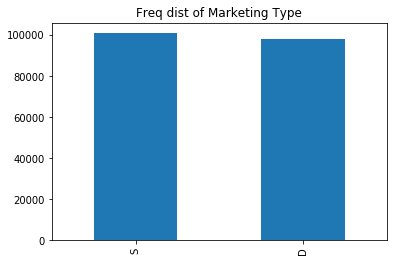

In [25]:
sales_data['MarketingType'].value_counts().plot.bar(title="Freq dist of Marketing Type")
plt.show()

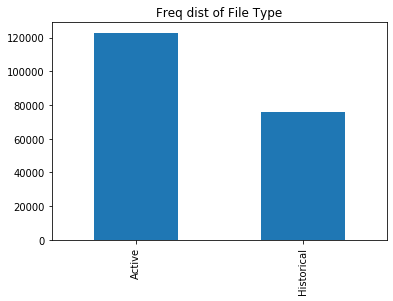

In [11]:
sales_data['File_Type'].value_counts().plot.bar(title="Freq dist of File Type")
plt.show()

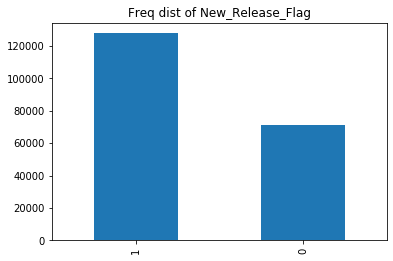

In [12]:
sales_data['New_Release_Flag'].value_counts().plot.bar(title="Freq dist of New_Release_Flag")
plt.show()

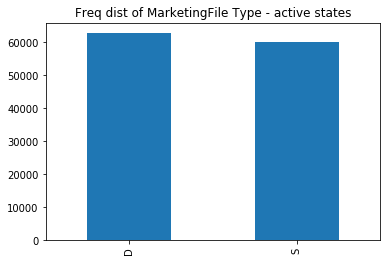

In [13]:
sales_data_act['MarketingType'].value_counts().plot.bar(title="Freq dist of MarketingFile Type - active states")
plt.show()

**Contexto teórico**

> Probability Density Function: PDF ou função de densidade de probabilidade em português, se refere a probabilidade de distribuição de uma variável aleatória contínua, em posição a uma variável aleatória discreta.

Em termos estatísticos, quando representamos o PDF graficamente, a área sob a curva indica o intervalo em que a variável analisada irá cair. A área total neste intervalo do gráfico é igual à probabilidade de ocorrência de uma variável aleatória contínua.

A função de densidade de probabilidade (PDF) não deve ser confundida com a função de massa de probabilidade (PMF). Esta última é aplicável a variáveis aleatórias discretas. A maneira mais fácil de diferenciar entre `variáveis discretas` versus `variáveis contínuas`, é que as discretas podem ser contadas (ou seja, o número é finito e normalmente assume a forma de um inteiro) e contínuas não (isto é, valores infinitos).

---

Agora podemos verificar a distribuição univariada das colunas numéricas que contém os histogramas e o PDF estimado.

Com exceção da coluna `ReleaseYear`, todas as demais tem uma inclinação para a esquerda. Isso indica que a coluna `ReleaseYear` tem a maioria de seus valores no intervalo superior, enquanto todas as demais estão no intervalo inferior.

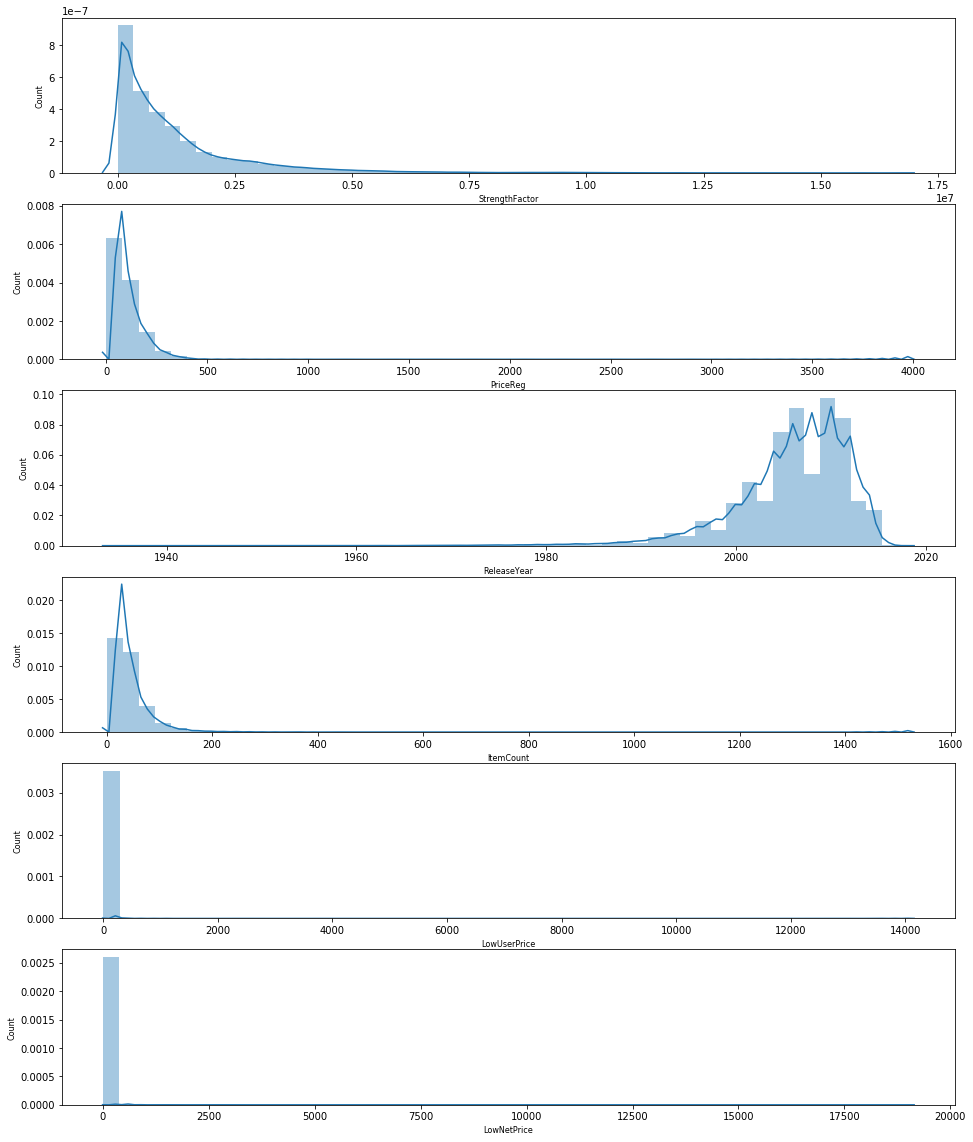

In [14]:
col_names = ['StrengthFactor','PriceReg', 'ReleaseYear', 'ItemCount', 'LowUserPrice', 'LowNetPrice']

fig, ax = plt.subplots(len(col_names), figsize=(16,20))

for i, col_val in enumerate(col_names):
    sns.distplot(sales_data_hist[col_val], hist=True, ax=ax[i])
    ax[i].set_xlabel(col_val, fontsize=8)
    ax[i].set_ylabel('Count', fontsize=8)

plt.show()

A vantagem de utilizar gráficos de distribuição `bivariada`, é que eles nos ajudam a estudar a relação entre duas variáveis. Utilizar um gráfico de dispersão pode ser extremamente útil nesses casos.

Frequentemente, procuramos nos gráficos de dispersão, aqueles que mostrem um padrão linear claro, com um declive crescente ou decrescente. 

Neste dataset em particular, não temos uma padrão claro de linearidade a ser investigado com maior cautela. Dito isso, sempre há espaço para derivar outros insights que possam ser úteis comparando a natureza dos gráficos entre as variáveis de interesse.

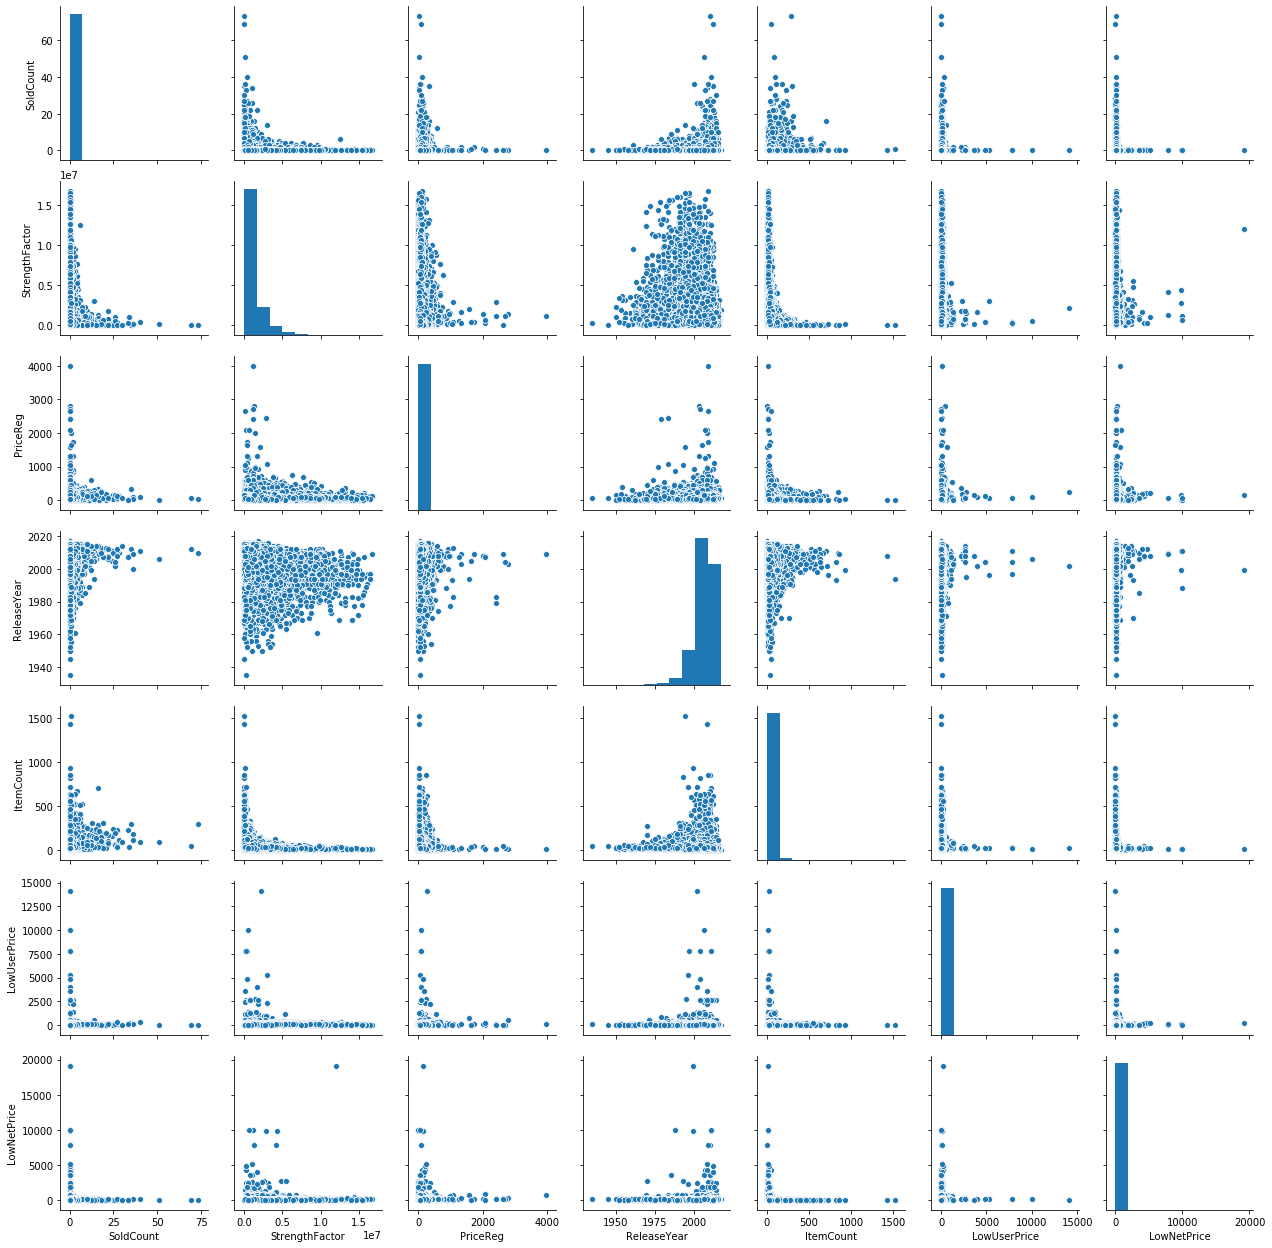

In [15]:
sales_data_hist = sales_data_hist.drop(['Order', 'File_Type','SKU_number','SoldFlag','MarketingType','ReleaseNumber','New_Release_Flag'], axis=1)
sns.pairplot(sales_data_hist)

### Procurando valores ausentes

Valores `ausentes` ou `omissos`, referem-se àqueles campos que estão vazios ou sem valores atribuídos (NULL). Isso geralmente ocorre devido a erros de entrada dos dados, falhas que ocorrem nos processos de coleta e muitas vezes ao unir várias colunas de diferentes tabelas, onde algumas condições podem levar aos valores ausentes. 

Existem inúmeras maneiras com as quais os valores ausentes são tratados, os mais fáceis são substituir o valor ausente pela média, mediana, modo ou valor constante/determinístico (chegamos a este valor baseado no conhecimento do domínio). O outra alternativa é remover toda linha onde este erro ocorra.

In [16]:
# verificar se existem valores nulos no dataset
sales_data.isnull().values.any()

True

In [17]:
# realiza a contagem dos números nulos no dataset
sales_data.isnull().sum()

Order                    0
File_Type                0
SKU_number               0
SoldFlag            122921
SoldCount           122921
MarketingType            0
ReleaseNumber            0
New_Release_Flag         0
StrengthFactor           0
PriceReg                 0
ReleaseYear              0
ItemCount                0
LowUserPrice             0
LowNetPrice              0
dtype: int64

Neste caso em específico vamos substituir estes valores nulos por 0. Após aplicar a transformação, podemos verificar novamente nosso dataset e observar que agora não temos mais dados nulos.

In [18]:
sales_data['SoldFlag'].fillna(0, inplace=True)

In [19]:
sales_data['SoldCount'].fillna(0, inplace=True)

In [20]:
sales_data.isnull().sum()

Order               0
File_Type           0
SKU_number          0
SoldFlag            0
SoldCount           0
MarketingType       0
ReleaseNumber       0
New_Release_Flag    0
StrengthFactor      0
PriceReg            0
ReleaseYear         0
ItemCount           0
LowUserPrice        0
LowNetPrice         0
dtype: int64

### Procurando por outliers

Um outlier pode indicar um erro nos dados (como erros de digitação, medição, efeitos sazonais, etc.), o que geralmente nos conduz a ação de correção. 

Diversas vezes as ações tomadas são a correção (caso seja possível identificar), e a retirada do registro no dataset. Isso é realizado para que estes dados não afetem os calculos estatísticos, ou gerem distribuições enganosas na hora de obter insights dos dados, o que nos conduzirá a uma análise incorreta.

Vamos utilizar a visualização do `boxplot` para identificar os outliers...

--- 

**Contexto teórico**

O boxplot ou diagrama de caixa é uma ferramenta gráfica que permite visualizar a distribuição e valores discrepantes (outliers) dos dados, fornecendo assim um meio complementar para desenvolver uma perspectiva sobre o caráter dos dados. Além disso, o boxplot também é uma disposição gráfica comparativa.

Para uma correta interpretação do boxplot, se faz necessário uma breve explicação sobre os quartis, que são as medidas estatísticas descritivas apresentadas no boxplot.

**Quartis e Percentil:** O percentil é uma medida de posição que, dada uma amostra ordenada em ordem crescente e dividida em 100 partes, indica o valor do qual determinado percentual de elementos da amostra são menores ou iguais a ele. No geral trabalhamos com $1/4$ do todo, definindo percentis de 25, 50 e 75.

Os quartis nada mais são que os percentis 25, 50 e 75, representando respectivamente o primeiro, segundo e terceiro quartil. O segundo quartil equivale ao percentil 50, valor em que pelo menos 50% da amostra está acima dele e pelo menos 50% está abaixo, ou seja, estamos falando da mediana.

![bp](https://fiapfunctions.blob.core.windows.net/datasets/boxplot-1.png)

Referência: [khanacademy.org/math/statistics-probability/identifying-outliers-iqr-rule](https://pt.khanacademy.org/math/statistics-probability/summarizing-quantitative-data/box-whisker-plots/a/identifying-outliers-iqr-rule)

---

Com base na definição acima, podemos concluir que as caixas coloridas são os itens na faixa de `IQR` (interquartile range), enquanto os pontos são nossos `outliers`.

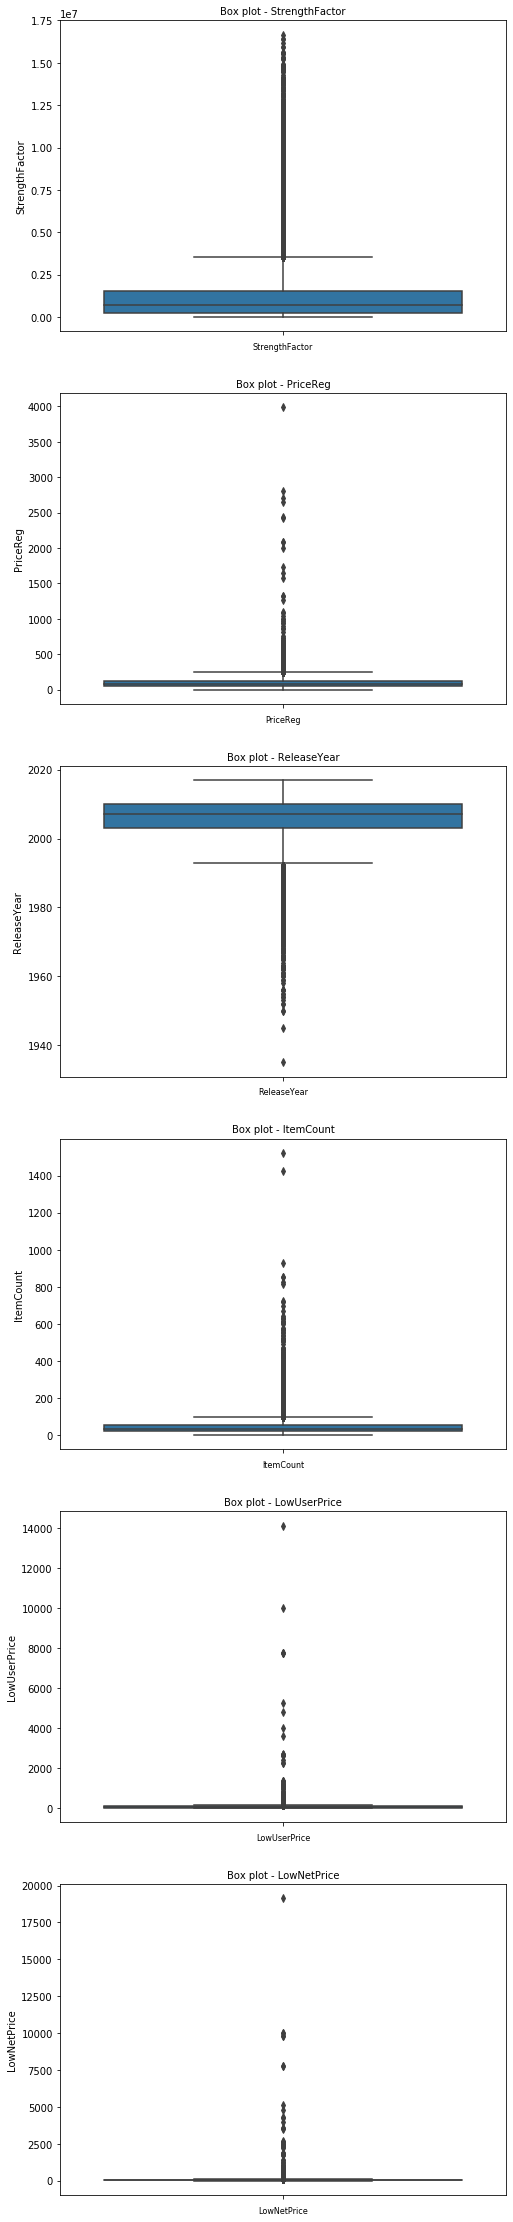

In [21]:
col_names = ['StrengthFactor','PriceReg', 'ReleaseYear', 'ItemCount', 'LowUserPrice', 'LowNetPrice']

fig, ax = plt.subplots(len(col_names), figsize=(8,40))

for i, col_val in enumerate(col_names):
    sns.boxplot(y=sales_data_hist[col_val], ax=ax[i])
    ax[i].set_title('Box plot - {}'.format(col_val), fontsize=10)
    ax[i].set_xlabel(col_val, fontsize=8)

plt.show()

### Tratando outliers

O próximo passo natural após a identificação de `outliers` em nossos dados, é realizar o devido tratamento, ou seja, remover os valores discrepantes.

Uma das técnicas mais utilizadas é remover os valores atípicos com base no `percentil`. Existem outras técnicas como `z-score`, então não deixe de pesquisar :)

Os valores marcados com um ponto abaixo do eixo x no gráfico, são aqueles que serão removidos com base no percentil definido (95 nesse caso).

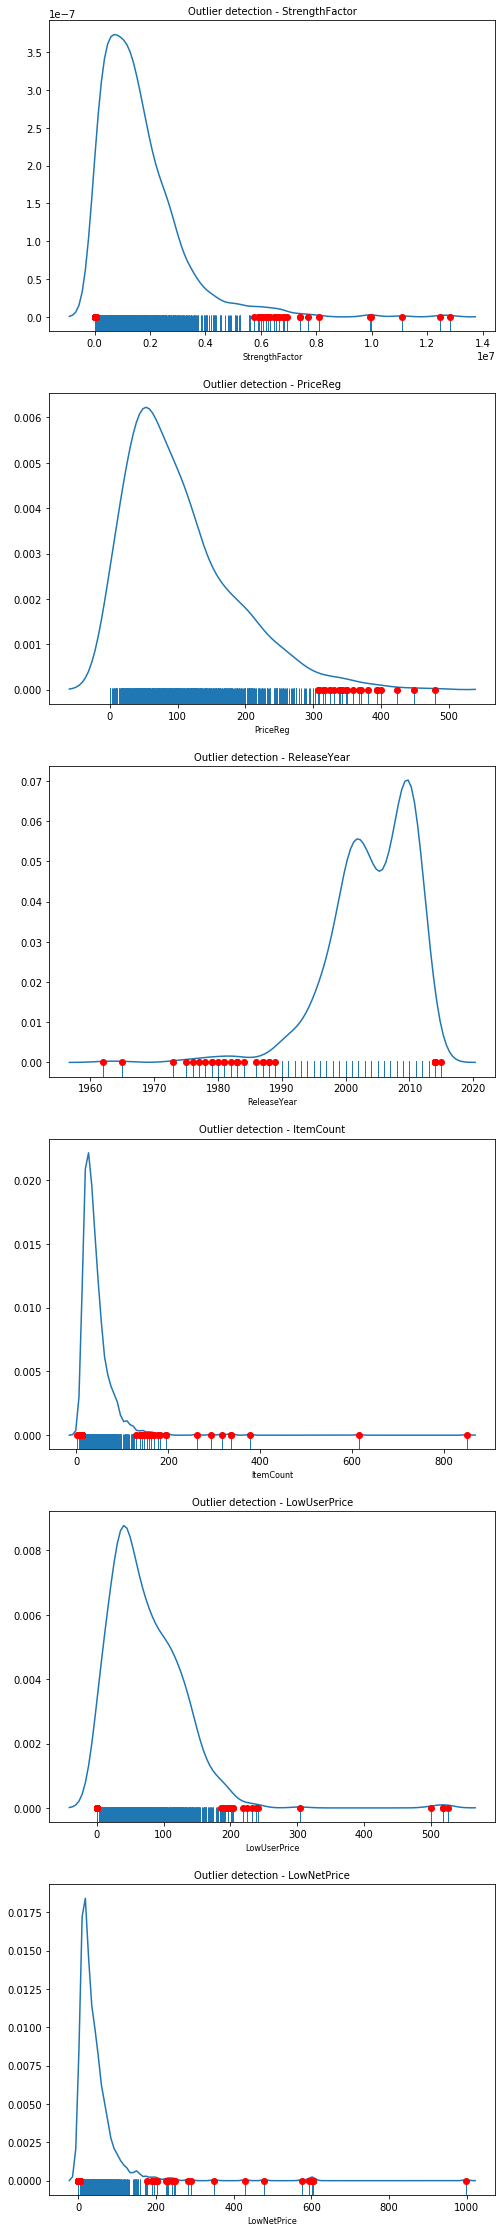

In [22]:
def percentile_based_outlier(data, threshold=95):
    diff = (100 - threshold) / 2
    minval, maxval = np.percentile(data, [diff, 100 - diff])
    return (data < minval) | (data > maxval)

col_names = ['StrengthFactor','PriceReg', 'ReleaseYear', 'ItemCount', 'LowUserPrice', 'LowNetPrice']

fig, ax = plt.subplots(len(col_names), figsize=(8,40))

for i, col_val in enumerate(col_names):
    x = sales_data_hist[col_val][:1000]
    sns.distplot(x, ax=ax[i], rug=True, hist=False)
    outliers = x[percentile_based_outlier(x)]
    ax[i].plot(outliers, np.zeros_like(outliers), 'ro', clip_on=False)

    ax[i].set_title('Outlier detection - {}'.format(col_val), fontsize=10)
    ax[i].set_xlabel(col_val, fontsize=8)

plt.show()

### Verificando a correlação

Uma matriz de correlação é uma tabela que mostra o valor do coeficiente de correlação, que são usados na estatística para medir a relação entre duas variáveis.

Cada atributo do conjunto de dados é comparado com os outros atributos para descobrir o coeficiente de correlação. Essa análise permite ver quais pares têm a correlação mais alta. Os pares que possuem um alto grau de correlação, representam a mesma variância do conjunto de dados, portanto, podemos analisá-los para entender qual atributo entre os pares é mais significativo para a construção do modelo.

Abaixo temos o resultado da nossa matriz de correlação. O valores variam entre -1 e +1. 

As variáveis altamente correlacionadas terão valor de correlação próximo a +1, e as variáveis com baixa correlação terão valor próximo a -1. Os valores diagonais são sempre 1, dado que falamos da correlação entre as mesmas variáveis.

Neste exemplo em questão, não encontramos nenhuma correlação clara, o que nos ajuda a inferir que todos os atributos são importantes e devem ser considerados para a construção de um modelo.

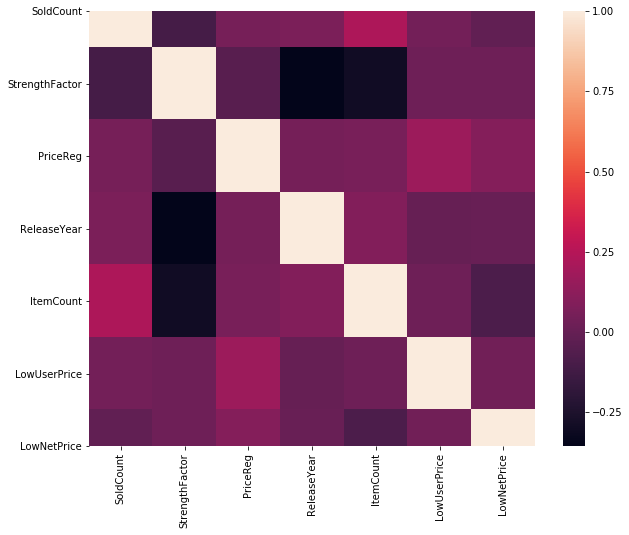

In [23]:
f, ax = plt.subplots(figsize=(10, 8))
corr = sales_data_hist.corr()
sns.heatmap(corr,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)